# QUBO Solution of the hydraulics equations
In this notebook we illustrate how to solve the hydraulics equations using a pure QUBO approach. 

## Hydraulics equations
In their most basic form the hydraulics equations read:

$$
    \sum_j q_{ij} - D_i = 0 \newline
    h_{L_{ij}} \equiv h_i - h_j = A |q_{ij}| q_{ij}^{B-1}
$$

where $h_i$ is the head pressure at node $i$, $A$ the resistance coefficient and $B$ the flow exponent. 
Several approximations have been developed for define $A$ and $B$. The popular Hazen-Williams (HW) approximation uses $B=1.852$. The HW is therefore not suited for a QUBO formulation that requires integer exponents in the formulation of the objective function. In contrast, the Chezy-Manning (CM) and Darcy-Weisbach (DW) approximation use $B=2$. We have implemented DW and CM hydraulics models that can found under `wntr_quantum/sim/models/`.


The presence of absolute values in the hydraulics equation makes it difficult to use the approach we just described. We therefore express the flow values as:

$$
    q_{ij} = s_{ij} |q_{ij}| \equiv s_{ij} y_{ij}
$$

This leads to the equations:

$$
    \sum_j s_{ij} y_{ij} - D_i = 0 \newline
    h_{L_{ij}} \equiv h_i - h_j = A s_{ij} y_{ij}^{B}
$$

In these forms the hydraulics equation can be seen as a system of non-linear equations with integeer power of the unknown: 

$$
F(s_{ij}, y_{ij}, h_i)=0
$$

 ## Solving non linear systems with a QUBO approach
 
 We closely following an approach developed in this [http://dx.doi.org/10.1038/s41598-019-46729-0](paper) to solve the non linear system. 
 
 
The method proposes to solve a non-linear system, given by $F(X) = 0$ by first decomposing the system of equations as a sum of tensor products:

$$
    F_i = P_i^{(0)} + \sum_j P_{ij}^{(1)}x_j + \sum_{jk} P_{ijk}^{(2)}x_j x_k + \sum_{jkl} P_{ijkl}^{(3)}x_j x_k x_l = 0 
$$

To find the solution of the system one can then minimise the residual sum of squares

$$
\chi^2 = \left[ P^{(0)} + P^{(1)} X + P^{(2)} X^2 + P^{(3)} X^3 + ... \right]^2
$$

By encoding all the variables as binary expansions we obtain a high order boolean polynomial. To solve this problem with a QUBO formalism, the high order terms have to be quadratized by introducing additional binary variables and appropriate terms in the loss function. The resulting QUBO problem can then be solved using either classical simulated annealing or quantum annealers alike.

## Example

We demonstrate in the following how to us our software to solve the hydraulics equations with a QUBO approach.

### Reference Solution

We first define the problem and solve it classically to obtain a benchmark solution

In [2]:
import wntr
import wntr_quantum
import numpy as np
import matplotlib.pyplot as plt
# Create a water network model

inp_file = '../networks/Net0.inp'
wn = wntr.network.WaterNetworkModel(inp_file)


## Run with the original EPANET simulator

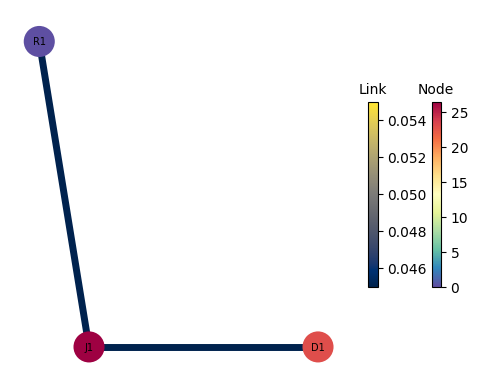

<Axes: >

In [3]:
sim = wntr.sim.EpanetSimulator(wn)
results = sim.run_sim()
# Plot results on the network
pressure_at_5hr = results.node['pressure'].loc[0, :]
flow_at_5hr = results.link['flowrate'].loc[0, :]
wntr.graphics.plot_network(wn, link_attribute=flow_at_5hr, 
                           node_attribute=pressure_at_5hr, 
                           node_size=500, 
                           link_width=5, 
                           node_labels=True,
                           link_cmap=plt.cm.cividis)

In [4]:
ref_pressure = results.node['pressure'].values[0][:2]
ref_rate = results.link['flowrate'].values[0]
ref_values = np.append(ref_rate, ref_pressure)
ref_values

array([ 0.05 ,  0.05 , 26.477, 22.954], dtype=float32)

## Run with the QUBO Polynomial Solver

In [5]:
wn = wntr.network.WaterNetworkModel(inp_file)

In [6]:
from wntr_quantum.sim.solvers.qubo_polynomial_solver import QuboPolynomialSolver
from qubops.solution_vector import SolutionVector_V2 as SolutionVector
from qubops.encodings import  RangedEfficientEncoding, PositiveQbitEncoding

nqbit = 7
step = (4./(2**nqbit-1))
flow_encoding = PositiveQbitEncoding(nqbit=nqbit, step=step, offset=+0, var_base_name="x")

nqbit = 7
step = (200/(2**nqbit-1))
head_encoding = PositiveQbitEncoding(nqbit=nqbit, step=step, offset=+0.0, var_base_name="x")

solver = QuboPolynomialSolver(wn, flow_encoding=flow_encoding, 
              head_encoding=head_encoding)
solver.verify_encoding()

Head Encoding : 0.000000 => 200.000000 (res: 1.574803)
Flow Encoding : -4.000000 => -0.000000 | 0.000000 => 4.000000 (res: 0.031496)


We then solve the QUBO equations classically. This gives us: a reference solution, the best possible encoded solution, the total encoded solution including all slack variables and the QUBO energy of the solution.

In [8]:
ref_sol, encoded_ref_sol, bin_rep_sol, eref, cvgd = solver.classical_solution()

/home/nico/miniconda3/envs/vitens_wntr_1/lib/python3.9/site-packages/quantum_newton_raphson/utils.py:74: SparseEfficiencyWarning: spsolve requires A be CSC or CSR matrix format
  warn("spsolve requires A be CSC or CSR matrix format", SparseEfficiencyWarning)


## Initial sample for the QUBO optimization 

Before minimizing the energy of the QUBO problem we need to define the initial configuration of the binary variables in the QUBO problem. We have implemented two different ways to obtain an initial sample that respects all the conditions imposed by the quadratization constraings of the polynomial qubo solver. 

We can for example create a completely random sample that simply ensure that quadratization constraints are respected

In [9]:
from wntr_quantum.sampler.simulated_annealing import modify_solution_sample
x = modify_solution_sample(solver, bin_rep_sol, modify=['flows', 'heads'])
x0 = list(x.values())

## Define the temperature schedule

The simulated annealing sampling requires a temperature schedule that needs to be carefully controlled to accept or reject the moves. 

In [10]:
num_sweeps = 2000
Tinit = 1E1
Tfinal = 1E-1
Tschedule = np.linspace(Tinit, Tfinal, num_sweeps)
Tschedule = np.append(Tschedule, Tfinal*np.ones(1000))
Tschedule = np.append(Tschedule, np.zeros(1000))

## Define the variables to optimize

We can select which variables a given optimizatio run changes to minimize the energy. In the example here, the first two variables are the signs of the flows, the two after that the absolute values of the flows and the last twos the head pressure. In the run below we first optimized all variables and then fine tune the values of the flows and then those of the head pressure.

In [14]:

optimize_value = [np.arange(2,6), np.arange(2,4), np.arange(4,6)]
status, msg, solution, results = solver.solve(x0, Tschedule, optimize_values=optimize_value, save_traj=True, verbose=False)
solver.step_func.verify_quadratic_constraints(results[-1].res)

100%|██████████| 4000/4000 [00:06<00:00, 664.99it/s]


We can plot the evolution of the QUBO energy and temperature to get an idea of the optimization process. 

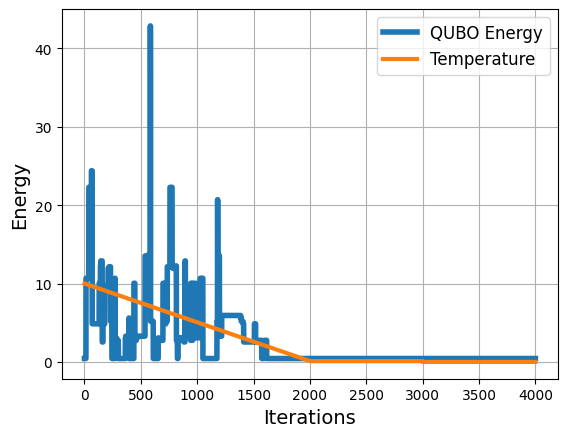

In [23]:
import matplotlib.pyplot as plt
eplt = results[-1].energies-eref[0]

left, bottom, width, height = [0.55, 0.55, 0.3, 0.3]

plt.plot(results[-1].energies[:]-eref, lw=4, label="QUBO Energy")
plt.plot(Tschedule, lw=3, label='Temperature')
plt.grid(which='both')


plt.ylabel('Energy', fontsize=14)
plt.xlabel('Iterations', fontsize=14)
plt.legend(fontsize=12)

Finally we can plo the solution obtained with our QUBO solver against the one obtained with the reference values

Text(0.5, 1.0, 'Pressure')

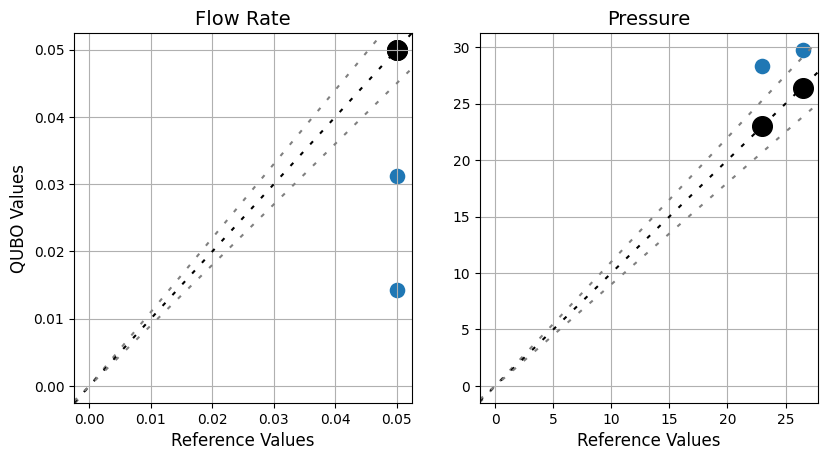

In [24]:
import matplotlib.pyplot as plt 

fig = plt.figure(figsize = plt.figaspect(0.5))
ax1 = fig.add_subplot(121)

ax1.axline((0, 0.0), slope=1.10, color="grey", linestyle=(0, (2, 5)))
ax1.axline((0, 0.0), slope=1, color="black", linestyle=(0, (2, 5)))
ax1.axline((0, 0.0), slope=0.90, color="grey", linestyle=(0, (2, 5)))
ax1.grid()

ax1.scatter(ref_values[:2], encoded_ref_sol[:2], c='black', s=200, label='Best solution')
ax1.scatter(ref_values[:2], solution[:2], s=150, lw=1, edgecolors='w', label='Sampled solution')


ax1.set_xlabel('Reference Values', fontsize=12)
ax1.set_ylabel('QUBO Values', fontsize=12)
ax1.set_title('Flow Rate', fontsize=14)

ax2 = fig.add_subplot(122)

ax2.axline((0, 0.0), slope=1.10, color="grey", linestyle=(0, (2, 5)))
ax2.axline((0, 0.0), slope=1, color="black", linestyle=(0, (2, 5)))
ax2.axline((0, 0.0), slope=0.90, color="grey", linestyle=(0, (2, 5)))


ax2.scatter(ref_values[2:], encoded_ref_sol[2:], c='black', s=200, label='Best solution')
ax2.scatter(ref_values[2:], solution[2:], s=150, lw=1, edgecolors='w', label='Sampled solution')
ax2.grid()


ax2.set_xlabel('Reference Values', fontsize=12)
ax2.set_title('Pressure', fontsize=14)